In [1]:
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from einops import rearrange
from PIL import Image
plt.rcParams['figure.figsize'] = [50, 10]


In [35]:
empty = torch.zeros((3, 8, 8))
full = torch.ones((3, 8, 8))
assign = torch.empty((2, 3, 8, 8))

el1 = torch.stack([empty, full, empty], dim=0)
el2 = torch.stack([empty, full, full], dim =0)
batch = torch.stack((el1, el2))

mask = batch != 0
((batch * mask).sum(dim=1) / mask.sum(dim=1)).shape

torch.Size([2, 3, 8, 8])

In [57]:
weights = torch.ones((11, 3, 8, 8))
softmax_mat = torch.full((2, 7, 3, 8, 8), float("-inf"))

view_delimiter = [(0, 4), (4, 11)]
view_index = [(0, 1, 2, 3, 4), (0, 7, 3, 2, 1), (5, 7, 1, 1, 1)]

softmax_mat[:, :, :, view_index] = 7
softmax_mat[:, :, :, view_index].shape

torch.Size([2, 7, 3, 3, 5, 8])

In [2]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
spoof = False
if not spoof:
    generated_batch = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/generated_batch.pt", map_location=torch.device("cpu"))
    logit_arr = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/logit_arr.pt", map_location=torch.device("cpu"))
    weight_arr = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/weight_arr.pt", map_location=torch.device("cpu"))
    target = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/target.pt", map_location=torch.device("cpu"))
    cond = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/cond.pt", map_location=torch.device("cpu"))
else:
    generated_batch = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/spoof_generated_batch.pt", map_location=torch.device("cpu"))
    logit_arr = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/spoof_logit_arr.pt", map_location=torch.device("cpu"))
    weight_arr = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/spoof_weight_arr.pt", map_location=torch.device("cpu"))
    target = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/target.pt", map_location=torch.device("cpu"))
    cond = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/spoof_cond.pt", map_location=torch.device("cpu"))

In [12]:
target = torch.zeros((12, 3, 64, 64))
mask = torch.stack(
                [torch.stack([target] * weight_arr.shape[2], dim=1)]
                * weight_arr.shape[1],
                dim=1,
            ) != 0
print(logit_arr.shape)
print(mask.shape)
weight_masked = logit_arr * mask

torch.Size([12, 8, 6, 3, 64, 64])
torch.Size([12, 8, 6, 3, 64, 64])


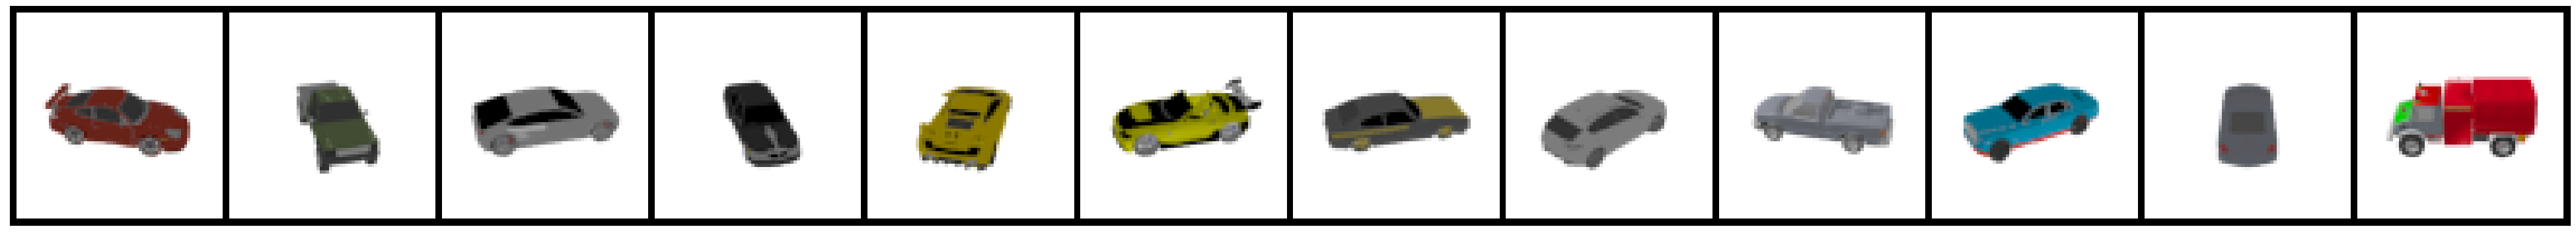

In [4]:
target_grid = make_grid(target, nrow=12)
show(target_grid)

torch.Size([3, 464, 662])


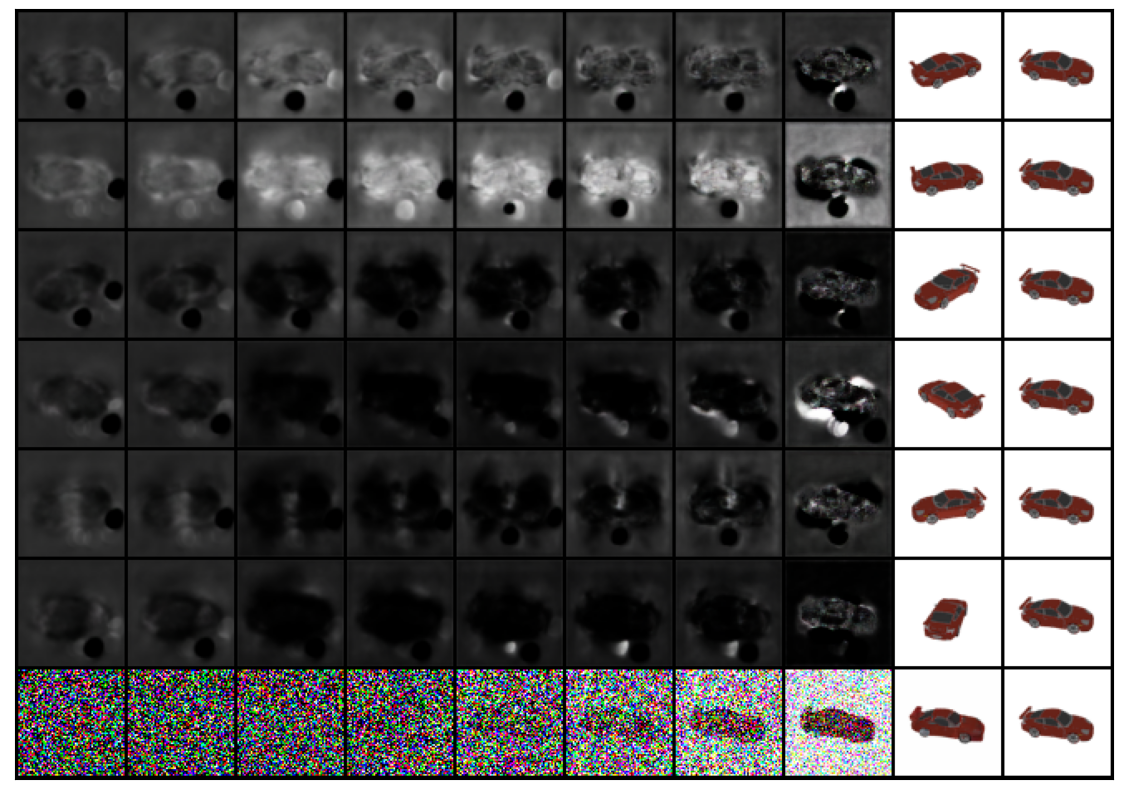

In [6]:
i = 0
target_grid = torch.cat([target[i, ...][None, ...],] * (cond.shape[1] + 1))[None, ...]
view_weights = torch.cat((weight_arr[i, ...], cond[i, :, :3, ...][None, ...]), dim=0)
view_weights = torch.cat((view_weights, torch.clamp(generated_batch[i, ...][:, None, ...], 0, 1)), dim=1)
view_weights = torch.cat((view_weights, target_grid))
view_weights = make_grid(rearrange(view_weights, "s v c h w -> (v s) c h w"), nrow=view_weights.shape[0], scale_each=True)
print(view_weights.shape)
show(view_weights)

In [47]:
n = 7
variable_generated_batch = torch.load(f"/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/variable_generated_batch_{n}.pt", map_location=torch.device("cpu"))
variable_logit_arr = torch.load(f"/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/variable_logit_arr_{n}.pt", map_location=torch.device("cpu"))
variable_weight_arr = torch.load(f"/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/variable_weight_arr_{n}.pt", map_location=torch.device("cpu"))
target = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/target.pt", map_location=torch.device("cpu"))
variable_cond = cond[:, :n, ...]
print(variable_weight_arr.shape)

torch.Size([12, 8, 6, 3, 64, 64])


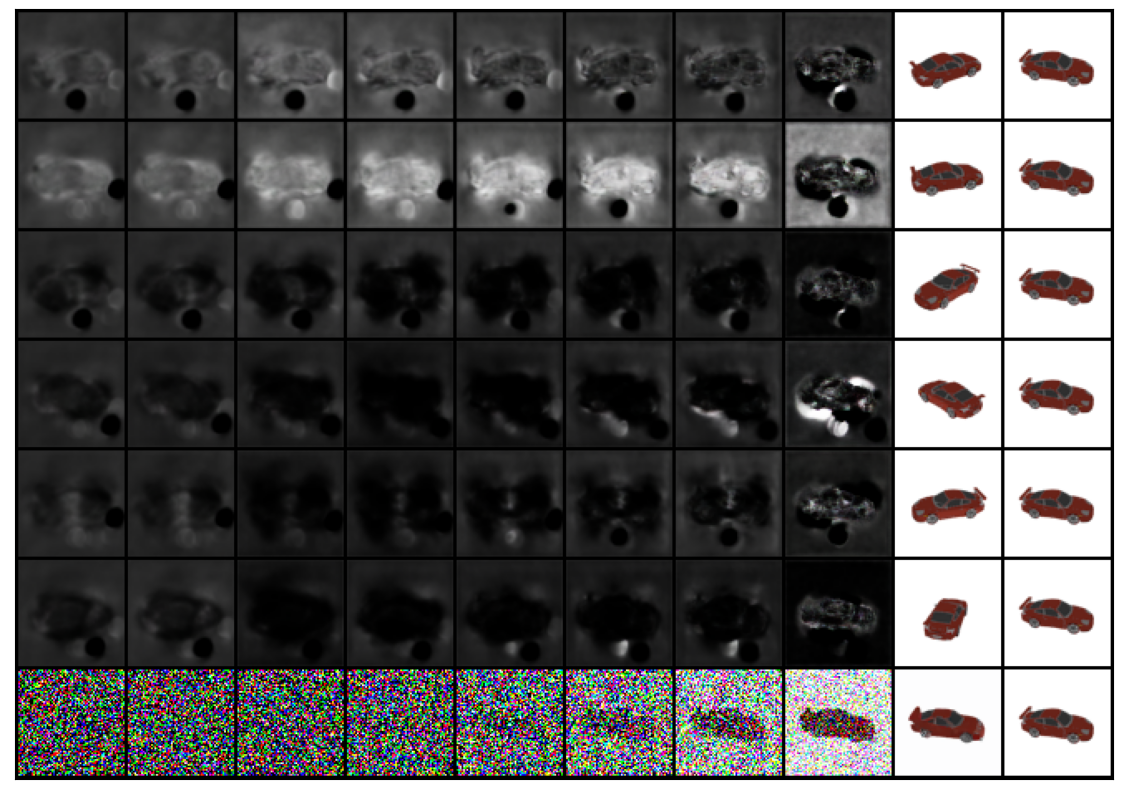

In [48]:
i = 0
target_grid = torch.cat([target[i, ...][None, ...],] * (variable_cond.shape[1] + 1))[None, ...]
view_weights = torch.cat((variable_weight_arr[i, ...], variable_cond[i, :, :3, ...][None, ...]), dim=0)
view_weights = torch.cat((view_weights, torch.clamp(variable_generated_batch[i, ...][:, None, ...], 0, 1)), dim=1)
view_weights = torch.cat((view_weights, target_grid))
view_weights = make_grid(rearrange(view_weights, "s v c h w -> (v s) c h w"), nrow=view_weights.shape[0], scale_each=True)
show(view_weights)